# 解析モデル
![](img/2d-mur/model.png)

# 各種パラメータ

In [57]:
%mkdir result
%rm result/*.png
%mkdir img/2d-mur

import numpy as np

# 解析領域の分割数
nx = 120
ny = 120 

nstep = 2000 # 計算ステップ総数

# セルサイズ
dx = 0.005
dy = 0.005

# 電界
ex = np.zeros((nx, ny))
ey = np.zeros((nx, ny))
ez = np.zeros((nx, ny))

# 磁界
hx = np.zeros((nx, ny))
hy = np.zeros((nx, ny))
hz = np.zeros((nx, ny))

# 係数
aex  = np.zeros((nx, ny))
aey  = np.zeros((nx, ny))
aez  = np.zeros((nx, ny))
bexy = np.zeros((nx, ny))
beyx = np.zeros((nx, ny))
bezx = np.zeros((nx, ny))
bezy = np.zeros((nx, ny))
amx  = np.zeros((nx, ny))
amy  = np.zeros((nx, ny))
amz  = np.zeros((nx, ny))
bmxy = np.zeros((nx, ny))
bmyx = np.zeros((nx, ny))
bmzx = np.zeros((nx, ny))
bmzy = np.zeros((nx, ny))

# 媒質定数
epsbk  = 1 # 背景媒質
mubk   = 1
sigebk = 0
sigmbk = 0
epsd  = np.full((nx+1, ny+1), epsbk ) # 比誘電率
sgmed = np.full((nx+1, ny+1), sigebk) # 導電率
mud   = np.full((nx+1, ny+1), mubk  ) # 比透磁率
sgmmd = np.full((nx+1, ny+1), sigmbk) # 磁気伝導率

# 誘電体
ic   = int(nx/2) # 中心
jc   = int(ny/2)
lx2  = 20        # 長さ
ly2  = 20
epsr = 3         # 比誘電率

# 電流源
duration = 0.1e-9         # パルス幅
t0       = 4.0 * duration # ピーク時刻
ifed = ic - lx2 - 20      # 給電位置
jfed = jc

# 自由空間
eps0 = 8.854188e-12
mu0  = 1.256637e-6
c    = 2.9979246e8



mkdir: cannot create directory ‘result’: File exists
rm: cannot remove 'result/*.png': No such file or directory
mkdir: cannot create directory ‘img/2d-mur’: File exists


# 初期化

In [58]:
t = 0
v  = c / np.sqrt(epsbk*mubk)
dt = 0.99999 / ( v * np.sqrt(1/(dx**2) + 1/(dy**2)) )

# 誘電体中の媒質定数
for j in range(jc - ly2, jc + ly2):
    for i in range(ic - lx2, ic + lx2):
        epsd[i][j]  = epsr
        mud[i][j]   = 1
        sgmed[i][j] = 0
        sgmmd[i][j] = 0

epsz  = (epsd[ifed][jfed] + epsd[ifed-1][jfed] + epsd[ifed][jfed-1] + epsd[ifed-1][jfed-1])/4 * eps0
befed = dt / epsz # 電流源の係数 

for j in range(ny):
    for i in range(nx):
        epsx = (epsd[i][j]  + epsd[i][j-1] )/2 * eps0
        sgex = (sgmed[i][j] + sgmed[i][j-1])/2    
        a = sgex /2 *dt / epsx
        aex[i][j]  = (1 - a)/(1 + a)
        beyx[i][j] = dt / epsx / (1 + a) /dy

        epsy = (epsd[i][j]  + epsd[i-1][j] )/2 * eps0
        sgey = (sgmed[i][j] + sgmed[i-1][j])/2
        a = sgey /2 *dt /epsy
        aey[i][j]  = (1 - a)/(1 + a)
        bexy[i][j] = dt / epsy / (1 + a) / dx

        epsz = (epsd[i][j]  + epsd[i-1][j]  + epsd[i][j-1]  + epsd[i-1][j-1] )/4 * eps0
        sgez = (sgmed[i][j] + sgmed[i-1][j] + sgmed[i][j-1] + sgmed[i-1][j-1])/4
        a = sgez /2 *dt /epsy
        aez[i][j]  = (1 - a)/(1 + a)
        bezy[i][j] = dt / epsz / (1 + a) / dy
        bezx[i][j] = dt / epsz / (1 + a) / dx

        mux = (mud[i][j]    + mud[i-1][j]  )/2 * mu0
        sgmx = (sgmmd[i][j] + sgmmd[i-1][j])/2
        a = sgmx /2 *dt / mux
        amx[i][j]  = (1 - a)/(1 + a)
        bmxy[i][j] = dt / mux / (1 + a) / dy

        muy = (mud[i][j] + mud[i][j-1])/2 * mu0
        sgmy = (sgmmd[i][j] + sgmmd[i][j-1])/2
        a = sgmy /2 *dt /muy
        amy[i][j]  = (1 - a)/(1 + a)
        bmyx[i][j] = dt / muy / (1 + a) / dx

        muz = mud[i][j] * mu0
        sgmz = sgmmd[i][j]
        a = sgmz /2 *dt /muz
        amz[i][j]  = (1 - a)/(1 + a)
        bmzx[i][j] = dt / muz / (1 + a) / dx
        bmzy[i][j] = dt / muz / (1 + a) / dy
    


可視化

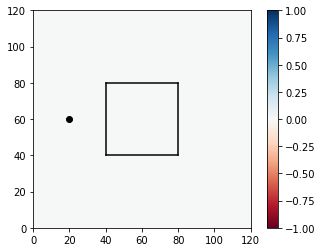

In [72]:
%mkdir result/2d-mur -p

import matplotlib.pyplot as plt

def plot_Ez(n, show=False):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    c = ax.pcolor(ez, cmap='RdBu', vmin=-1, vmax=1)
    fig.colorbar(c, ax=ax)

    plt.scatter(ifed, jfed, color='black')

    plt.plot([ic-lx2, ic-lx2], [jc-lx2, jc+lx2], color='black')
    plt.plot([ic+lx2, ic+lx2], [jc-lx2, jc+lx2], color='black')
    plt.plot([ic-lx2, ic+lx2], [jc-lx2, jc-lx2], color='black')
    plt.plot([ic-lx2, ic+lx2], [jc+lx2, jc+lx2], color='black')

    plt.savefig('result/2d-mur/{}.png'.format(n),  facecolor="white", edgecolor="coral")
    if show:
        plt.show()

plot_Ez(0, True)

# 電流源

In [59]:
def feed():
    iz = np.exp(-((t - 0.5*dt - t0)/duration)**2)
    ez[ifed][jfed] -= befed * iz/(dx*dy)

# 電磁界の計算

In [60]:
def e_cal():
    # Ex
    for j in range(1, ny-1):
        for i in range(0, nx-1):
            ex[i][j] = aex[i][j] * ex[i][j] + bexy[i][j] * (hz[i][j] - hz[i][j-1])
    
    # Ey
    for j in range(0, ny-1):
        for i in range(1, nx-1):
            ey[i][j] = aey[i][j] * ey[i][j] + beyx[i][j] * (hz[i][j] - hz[i-1][j])

    # Ez
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            ez[i][j] = aez[i][j] * ez[i][j] + bezx[i][j] * (hy[i][j] - hy[i-1][j]) - bezy[i][j] * (hx[i][j] - hx[i][j-1])

def h_cal():
    # Hx
    for j in range(1, ny-1):
        for i in range(0, nx-1):
            hx[i][j] = amx[i][j] * hx[i][j] + bmxy[i][j] * (ez[i][j+1] - ez[i][j])
    
    # Hy
    for j in range(0, ny-1):
        for i in range(1, nx-1):
            hy[i][j] = amy[i][j] * hy[i][j] + bmyx[i][j] * (ez[i+1][j] - ez[i][j])

    # Hz
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            hz[i][j] = amz[i][j] * hz[i][j] - bmzx[i][j] * (ey[i+1][j] - ey[i][j]) + bmzy[i][j] * (ex[i][j+1] - ex[i][j])



# 吸収境界条件
境界条件の初期化

In [61]:
# 過去の電界
eyl1, eyl1p, eyl0, eyl0p  = (np.zeros(ny),) * 4
eyr1, eyr1p, eyr0, eyr0p  = (np.zeros(ny),) * 4
ezl1, ezl1p, ezl0, ezl0p  = (np.zeros(ny),) * 4
ezr1, ezr1p, ezr0, ezr0p  = (np.zeros(ny),) * 4
exd1, exd1p, exd0, exd0p  = (np.zeros(nx),) * 4
exu1, exu1p, exu0, exu0p  = (np.zeros(nx),) * 4
ezd1, ezd1p, ezd0, ezd0p  = (np.zeros(nx),) * 4
ezu1, ezu1p, ezu0, ezu0p  = (np.zeros(nx),) * 4

# 係数
eyml1, eyml2, eyml3 = (np.zeros(ny),) * 3
eymr1, eymr2, eymr3 = (np.zeros(ny),) * 3
ezml1, ezml2, ezml3 = (np.zeros(ny),) * 3
ezmr1, ezmr2, ezmr3 = (np.zeros(ny),) * 3
exmd1, exmd2, exmd3 = (np.zeros(nx),) * 3
exmu1, exmu2, exmu3 = (np.zeros(nx),) * 3
ezmd1, ezmd2, ezmd3 = (np.zeros(nx),) * 3
ezmu1, ezmu2, ezmu3 = (np.zeros(nx),) * 3


def initmur():
    # 左右の境界におけるEy
    for j in range(0, ny-1):
        v = c / np.sqrt(epsd[0][j])
        eyml1[j] = (v*dt - dx)/(v*dt + dx)
        eyml2[j] = 2 * dx / (v*dt + dx)
        eyml3[j] = dx / 2 / (v*dt + dx) * (v * dt / dy)**2

        v = c / np.sqrt(epsd[nx-1][j])
        eymr1[j] = (v*dt - dx)/(v*dt + dx)
        eymr2[j] = 2 * dx / (v*dt + dx)
        eymr3[j] = dx / 2 / (v*dt + dx) * (v * dt / dy)**2
    
    # 左右の境界におけるEz
    for j in range(1, ny-1):
        v = c / np.sqrt( (epsd[0][j] + epsd[0][j-1])/2 )
        ezml1[j] = (v*dt - dx)/(v*dt + dx)
        ezml2[j] = 2 * dx / (v*dt + dx)
        ezml3[j] = dx / 2 / (v*dt + dx) * (v*dt/dy)**2

        v = c / np.sqrt((epsd[nx-1][j] + epsd[nx-1][j-1])/2)
        ezmr1[j] = (v*dt - dx)/(v*dt + dx)
        ezmr2[j] = 2 * dx / (v*dt + dx)
        ezmr3[j] = dx / 2 / (v*dt + dx) * (v*dt/dy)**2
    
    # 上下の境界におけるEx
    for i in range(nx-1):
        v = c / np.sqrt(epsd[i][0])
        exmd1[i] = (v*dt - dy)/(v*dt + dy)
        exmd2[i] = 2 * dy / (v*dt + dy)
        exmd3[i] = dy / 2 / (v*dt + dy) * (v*dt/dx)**2

        v = c / np.sqrt(epsd[i][ny-1])
        exmu1[i] = (v*dt - dy)/(v*dt + dy)
        exmu2[i] = 2 * dy / (v*dt + dy)
        exmu3[i] = dy / 2 / (v*dt + dy) * (v*dt/dx)**2
    
    # 上下の境界におけるEz
    for i in range(1, nx-1):
        v = c / np.sqrt((epsd[i][0] + epsd[i-1][0])/2)
        ezmd1[i] = (v*dt - dy)/(v*dt + dy)
        ezmd2[i] = 2 * dy / (v*dt + dy)
        ezmd3[i] = dy / 2 / (v*dt + dy) * (v*dt/dx)**2

        v = c / np.sqrt((epsd[i][ny-1] + epsd[i-1][ny-1])/2)
        ezmu1[i] = (v*dt - dy)/(v*dt + dy)
        ezmu2[i] = 2 * dy / (v*dt + dy)
        ezmu3[i] = dy / 2 / (v*dt + dy) * (v*dt/dx)**2
        

吸収境界条件

In [62]:
def mur2nd():
    """ 左右の境界におけるEy """
    ey[0][0]     = eyl1[0] + eyml1[0] * (ey[1][0] - eyl0[0])
    ey[0][ny-1]  = eyl1[ny-1] + eyml1[ny-1] * (ey[1][ny-1] - eyl0[ny-1])
    ey[nx][0]    = eyr1[0] + eymr1[0] * (ey[nx-1][0] - eyr0[0])
    ey[nx][ny-1] = eyr1[ny-1] + eymr1[ny-1] * (ey[nx-1][ny-1] - eyr0[ny-1])

    # 2次Mur
    for j in range(1, ny-2):
        ey[0][j] = -eyl1p[j] + eyml1[j] * (ey[1][0] + eyl0p[j]) \
                    + eyml2[j] * (eyl0[j] + eyl1[j]) \
                    + eyml3[j] * (eyl0[j+1] - 2*eyl0[j] + eyl0[j-1] + eyl1[j+1] - 2*eyl1[j] + eyl1[j-1])

        ey[nx][j] = -eyr1p[j] + eymr1[j] * (ey[nx-1][j] + eyr0p[j]) \
                    + eymr2[j] * (eyr0[j] + eyr1[j]) \
                    + eymr3[j] * (eyr0[j+1] - 2*eyr0[j] + eyr0[j-1] + eyr1[j+1] - 2*eyr1[j] + eyr1[j-1])

    # 電界の保存
    for j in range(ny-1):
        eyl1p[j] = eyl1[j]
        eyl1[j]  = ey[1][j]
        eyl0p[j] = eyl0[j]
        eyl0[j]  = ey[0][j]

        eyr1p[j] = eyr1[j]
        eyr1[j]  = ey[nx-1][j]
        eyr0p[j] = eyr0[j]
        eyr0[j]  = ey[nx][j]

    """左右の境界におけるE_z"""
    ez[0][1]     = ezl1[1] + ezml1[1] * (ez[1][1] - ezl0[1])
    ez[0][nx-1]  = ezl1[ny-1] + ezml1[ny-1] * (ez[nx-1][1] - ezl0[ny-1])
    ez[nx][1]    = ezr1[1] + ezmr1[1] * (ez[nx-1][1] - ezr0[1])
    ez[nx][ny-1] = ezr1[ny-1] + ezmr1[ny-1] * (ez[nx-1][ny-1] - ezr0[ny-1])

    # 2次Mur
    for j in range(2, ny-2):
        ez[0][j] = -ezl1p[j] + ezml1[j] * (ez[1][j] + ezl0p[j]) \
                    + ezml2[j] * (ezl0[j] + ezl1[j]) \
                    + ezml3[j] * (ezl0[j+1] - 2*ezl0[j] + ezl0[j-1] + ezl1[j+1] - 2*ezl1[j] + ezl1[j-1])
        
        ez[nx][j] = -ezr1p[j] + ezmr1[j] * (ez[nx-1][j] + ezr0p[j]) \
                    + ezmr2[j] * (ezr0[j] + ezr1[j]) \
                    + ezmr3[j] * (ezr0[j+1] - 2*ezr0[j] + ezr0[j-1] + ezr1[j+1] - 2*ezr1[j-1])
    
    # 電界の保存
    for j in range(1,ny-1):
        ezl1p[j] = ezl1[j]
        ezl1[j]  = ez[1][j]
        ezl0p[j] = ezl0[j]
        ezl0[j]  = ez[0][j]
        
        ezr1p[j] = ezr1[j]
        ezr1[j]  = ez[nx-1][j]
        ezr0p[j] = ezr0[j]
        ezr0[j]  = ez[nx][j]

    """上下の境界におけるE_x"""
    ex[0][0]     = exd1[0] + exmd1[0] * (ex[0][1] - exd0[0])
    ex[nx-1][0]  = exd1[nx-1] + exmd1[nx-1] * (ex[nx-1][1] - exd0[nx-1])
    ex[0][ny]    = exu1[0] + exmu1[0] * (ex[0][ny-1] - exu0[0])
    ex[nx-1][ny] = exu1[nx-1] + exmu1[nx-1] * (ex[nx-1][ny-1] - exu0[nx-1])

    # 2次Mur
    for i in range(1, nx-2):
        ex[i][0]  = -exd1p[i] + exmd1[i] * (ex[i][0] - exd0p[i]) \
                    + exmd2[i] * (exd0[i] + exd1[i]) \
                    + exmd3[i] * (exd0[i+1] - 2*exd0[i] + exd0[i-1] + exd1[i+1] - 2*exd1[i] + exd1[i-1])

        ex[i][ny] = -exu1p[i] + exmu1[i] * (ex[i][ny-1] + exu0p[i]) \
                    + exmu2[i] * (exu0[i] + exu1[i]) \
                    + exmu3[i] * (exu0[i+1] - 2*exu0[i] + exu0[i-1] + exu1[i+1] - 2*exu1[i] + exu1[i-1])
    
    # 電界の保存
    for i in range(nx-1):
        exd1p[i] = exd1[i]
        exd1[i]  = ex[i][1]
        exd0p[i] = exd0[i]
        exd0[i]  = ex[i][0]

        exu1p[i] = exu1[i]
        exu1[i]  = ex[i][ny-1]
        exu0p[i] = exu0[i]
        exu0[i]  = ex[i][ny]

    """上下の境界におけるEz"""
    ez[1][0]       = ezd1[1] + ezmd1[1] * (ez[1][1] - ezd0[1])
    ez[nx-1][0]    = ezd1[nx-1] + ezmd1[nx-1] * (ez[nx-1][1] - ezd0[nx-1])
    ez[1][ny]      = ezu1[1] + ezmu1[1] * (ez[1][ny-1] - ezu0[1])
    ez[nx-1][ny-1] = ezu1[nx-1] + ezmu1[nx-1] * (ez[nx-1][ny-1] - ezu0[nx-1])

    # 2次Mur
    for i in range(2, nx-2):
        ez[i][0] = -ezd1p[i] + ezmd1[i] * (ez[i][1] + ezd0p[i]) \
                    + ezmd2[i] * (ezd0[i] + ezd1[i]) \
                    + ezmd3[i] * (ezd0[i+1] - 2*ezd0[i] + ezd0[i-1] + ezd1[i+1] - 2*ezd1[i] + ezd1[i-1])
        
        ez[i][ny] = -ezu1p[i] + ezmu1[i] * (ez[i][ny-1] + ezu0p[i]) \
                    + ezmu2[i] * (ezu0[i] + ezu1[i]) \
                    + ezmu3[i] * (ezu0[i+1] - 2*ezu0[i] + ezu0[i-1] + ezu1[i+1] - 2*ezu1[i] + ezu1[i-1])
    
    # 電界の保存
    for i in range(1, nx-1):
        ezd1p[i] = ezd1[i]
        ezd1[i]  = ez[i][1]
        ezd0p[i] = ezd0[i]
        ezd0[i]  = ez[i][0]

        ezu1p[i] = ezu1[i]
        ezu1[i]  = ez[i][ny-1]
        ezu0p[i] = ezu0[i]
        ezu0[i]  = ez[i][ny]


# FDTD

In [63]:
initmur()

t = dt
for n in range(1, nstep):
    e_cal()
    feed()
    mur2nd()

    t += dt/2

    h_cal()

    t += dt/2

    if n % 5 == 0:
        plot_Ez(n)


IndexError: index 120 is out of bounds for axis 0 with size 120